<a href="https://colab.research.google.com/github/21130227-LeNhutTruong/machine-learning/blob/main/Project_ML_21130227_LeNhutTruong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample


data = pd.read_excel('Dry_Bean_Dataset.xlsx')
print("Columns in the DataFrame:")
print(data.columns)
print(data.dtypes)
print(data.info())
print(data.describe())



Columns in the DataFrame:
Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')
Area                 int64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea           int64
EquivDiameter      float64
Extent             float64
Solidity           float64
roundness          float64
Compactness        float64
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
Class               object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0  

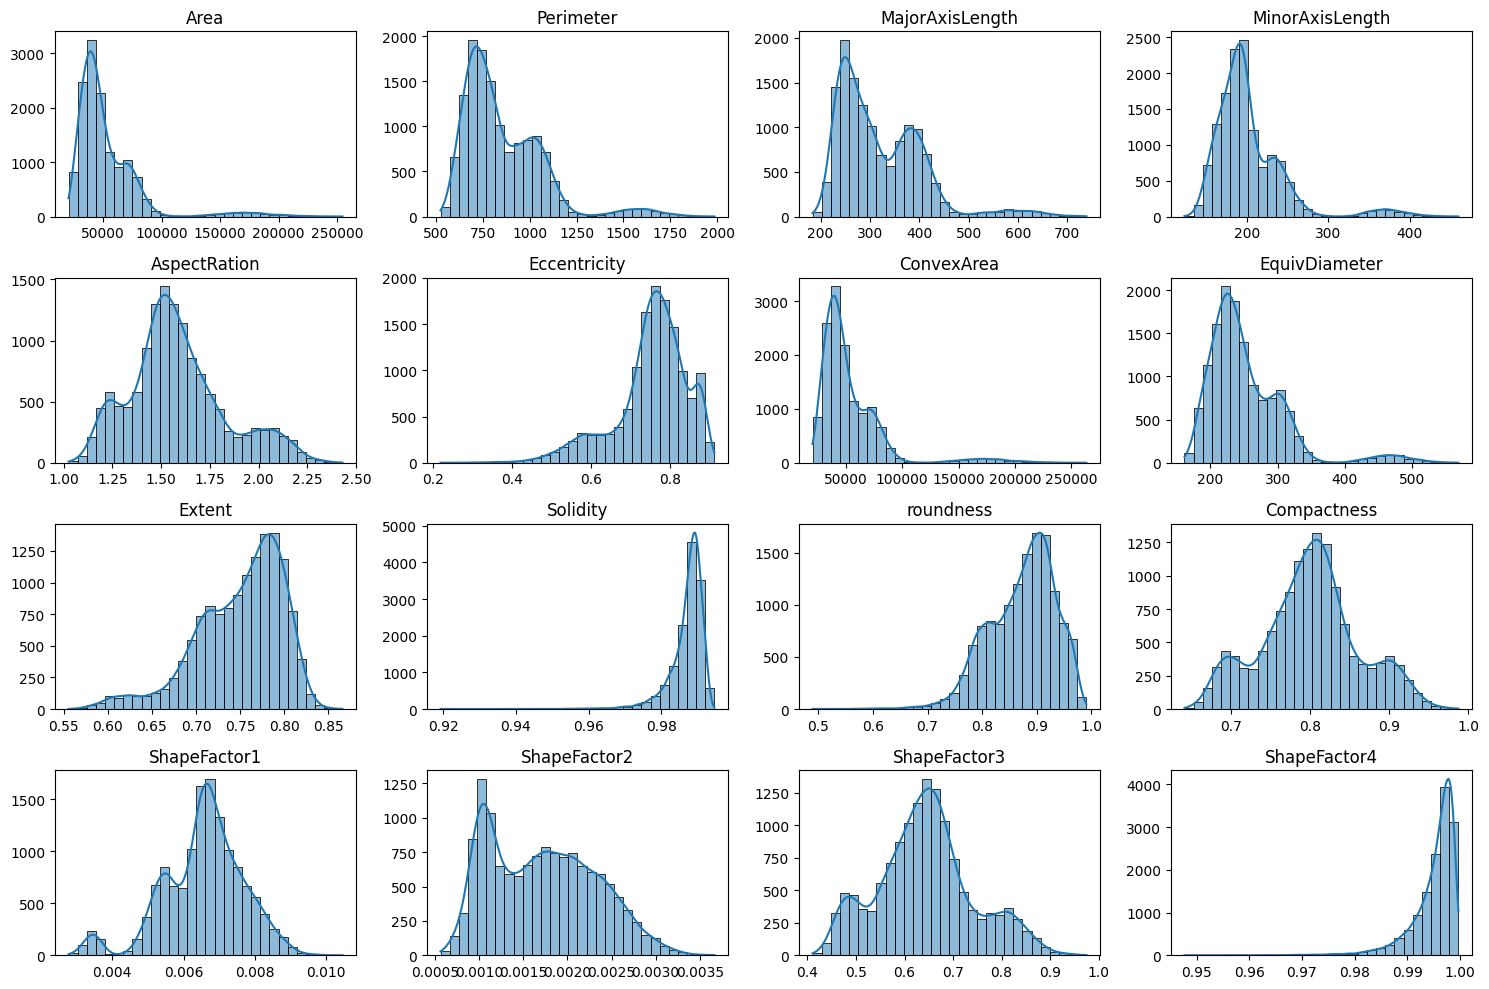

In [37]:
def plot_histograms(data, columns, bins=30):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns):
        if col in data.columns:
            plt.subplot(4, 4, i + 1)
            sns.histplot(data[col], bins=bins, kde=True)
            plt.title(col)
            plt.xlabel('')
            plt.ylabel('')
    plt.tight_layout()
    plt.show()

attributes = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation',
              'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity',
              'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3',
              'ShapeFactor4']
plot_histograms(data, attributes)

In [38]:




# Xử lý dữ liệu thiếu
# Loại bỏ các giá trị missing
data = data.dropna()

# Kiểm tra xem cột 'Class' có tồn tại không
if 'Class' not in data.columns:
    raise ValueError("Cột 'Class' không tồn tại trong DataFrame. Vui lòng kiểm tra dữ liệu của bạn.")

# Chọn lọc đặc trưng
# Chọn ra 10 thuộc tính tốt nhất
k = 10
X = data.drop('Class', axis=1)
y = data['Class']

# Kiểm tra kích thước của X trước khi chọn lọc đặc trưng
print("Shape of X before feature selection:", X.shape)
print("Shape of y:", y.shape)

# Nếu X có ít hơn k thuộc tính, điều chỉnh k cho phù hợp
k = min(k, X.shape[1])

selector = SelectKBest(f_classif, k=k)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Các thuộc tính được chọn:", selected_features)

# Cập nhật X với các thuộc tính đã chọn
X = X[selected_features]

# Kiểm tra kích thước của X sau khi chọn lọc đặc trưng
print("Shape of X after feature selection:", X.shape)

# Rời rạc hóa
try:
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
    X_binned = binner.fit_transform(X)
    X = pd.DataFrame(X_binned, columns=selected_features)  # Cập nhật X với dữ liệu đã rời rạc hóa
    print("Shape of X after binning:", X.shape)
except Exception as e:
    print("Error during binning:", e)
    # Nếu có lỗi trong rời rạc hóa, bỏ qua bước này và tiếp tục

# Xử lý dữ liệu không cân bằng
try:
    majority_class = data[data['Class'] == 0]
    minority_class = data[data['Class'] == 1]
    if len(minority_class) > 0:
        minority_upsampled = resample(minority_class,
                                      replace=True,
                                      n_samples=len(majority_class),
                                      random_state=123)
        data_balanced = pd.concat([majority_class, minority_upsampled])

        # Cập nhật X và y từ dữ liệu cân bằng
        X = data_balanced[selected_features]
        y = data_balanced['Class']
        print("Shape of X after balancing data:", X.shape)
    else:
        raise ValueError("Lớp thiểu số không có dữ liệu để cân bằng.")
except Exception as e:
    print("Error during balancing data:", e)
    # Nếu có lỗi trong cân bằng dữ liệu, bỏ qua bước này và tiếp tục

# Kiểm tra kích thước của X và y trước khi chuẩn hóa
if X.shape[0] == 0:
    raise ValueError("DataFrame X là rỗng sau khi cân bằng dữ liệu. Vui lòng kiểm tra dữ liệu của bạn.")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
try:
    X = scaler.fit_transform(X)
    print("Shape of X after scaling:", X.shape)
    print("Shape of y:", y.shape)
except Exception as e:
    print("Error during scaling:", e)
    # Nếu có lỗi trong chuẩn hóa, bạn có thể không thể tiếp tục với mô hình huấn luyện

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print("Tập huấn luyện: ", X_train.shape, y_train.shape)
    print("Tập kiểm tra: ", X_test.shape, y_test.shape)
except ValueError as e:
    print("Error during train-test split:", e)
    # Nếu không thể chia dữ liệu, cần xem xét lại quá trình chuẩn bị dữ liệu


Shape of X before feature selection: (13611, 16)
Shape of y: (13611,)
Các thuộc tính được chọn: Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'ConvexArea', 'EquivDiameter', 'Compactness',
       'ShapeFactor1', 'ShapeFactor2'],
      dtype='object')
Shape of X after feature selection: (13611, 10)
Shape of X after binning: (13611, 10)
Error during balancing data: Lớp thiểu số không có dữ liệu để cân bằng.
Shape of X after scaling: (13611, 10)
Shape of y: (13611,)
Tập huấn luyện:  (9527, 10) (9527,)
Tập kiểm tra:  (4084, 10) (4084,)


In [39]:
# Xây dựng và huấn luyện mô hình
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(max_iter=300)
}

param_grids = {
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10]
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
    },
    "Neural Network": {
        "hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
        "activation": ["tanh", "relu"],
        "solver": ["sgd", "adam"],
        "learning_rate": ["constant", "adaptive"]
    }
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_model = model

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[model_name] = {
        "Model": best_model,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Đánh giá mô hình
results_df = pd.DataFrame(results).T
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']])


Training Decision Tree...
Training Naive Bayes...
Training K-Nearest Neighbors...
Training Neural Network...
                     Accuracy Precision    Recall  F1 Score
Decision Tree        0.793585  0.814494  0.793585   0.79331
Naive Bayes          0.642507  0.742048  0.642507  0.590278
K-Nearest Neighbors  0.785015  0.800577  0.785015  0.786581
Neural Network       0.794074   0.81457  0.794074  0.793978


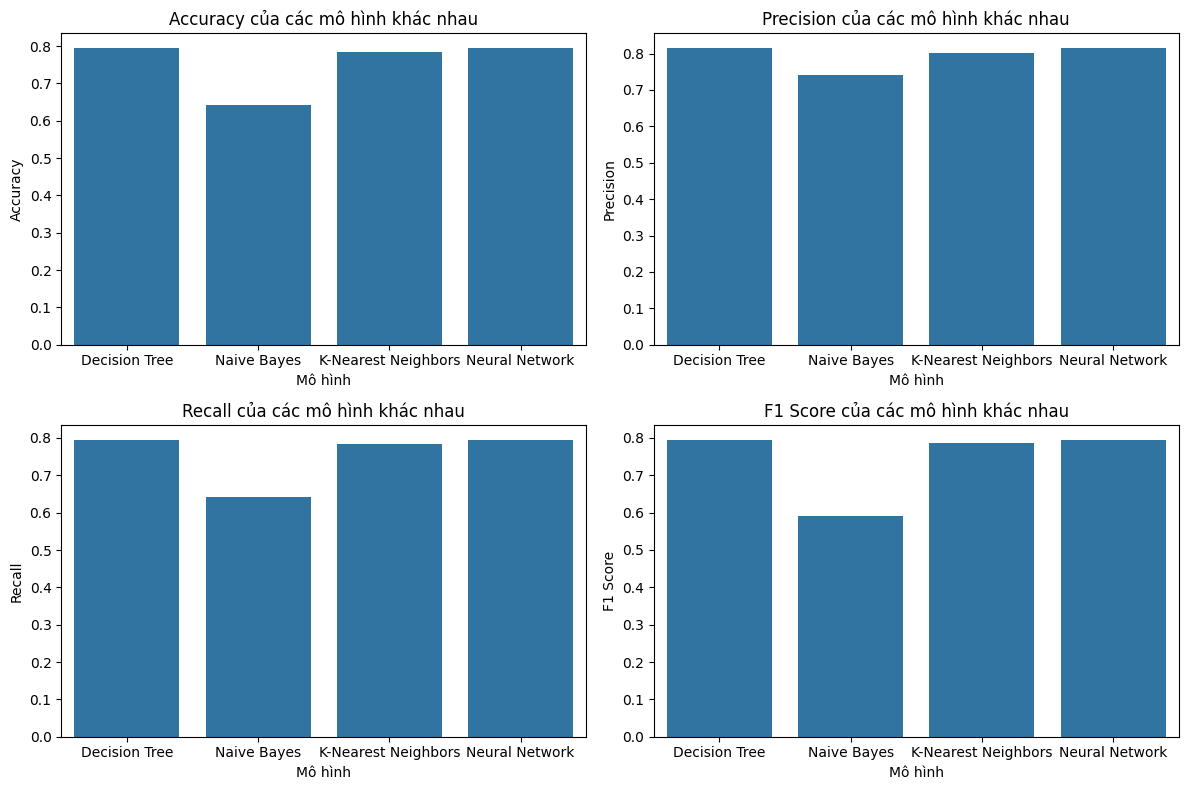

In [40]:
# Vẽ biểu đồ so sánh các độ đo
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x=results_df.index, y=results_df[metric])
    plt.title(f'{metric} của các mô hình khác nhau')
    plt.xlabel('Mô hình')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


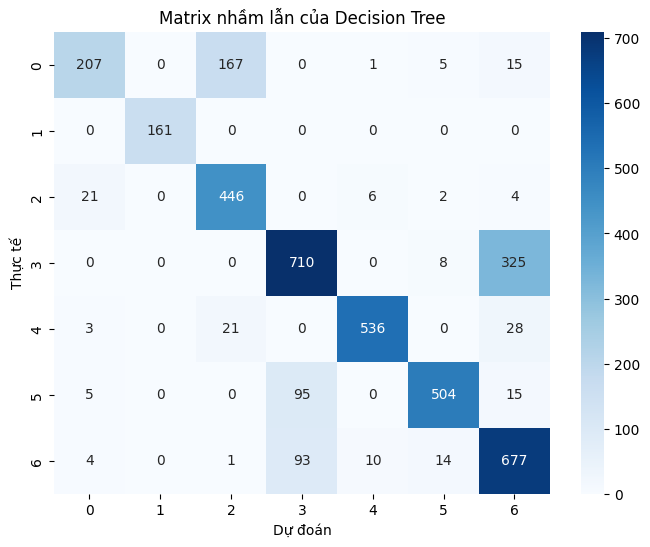

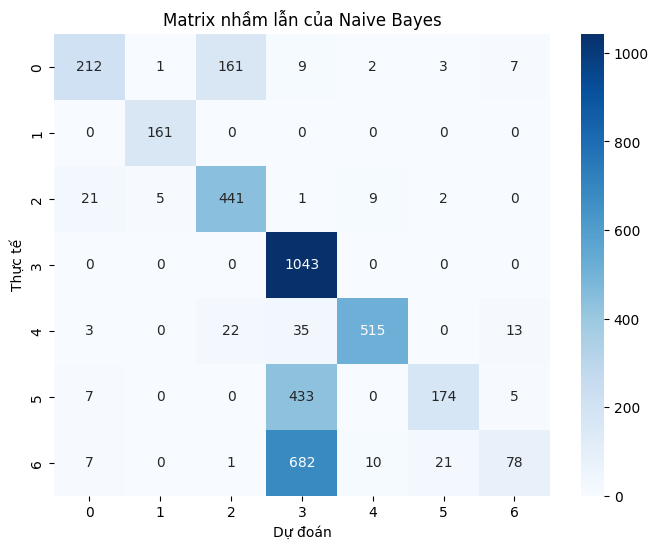

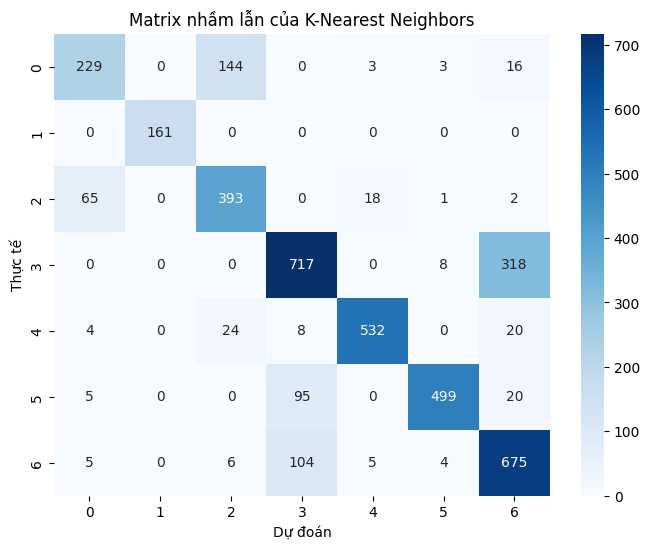

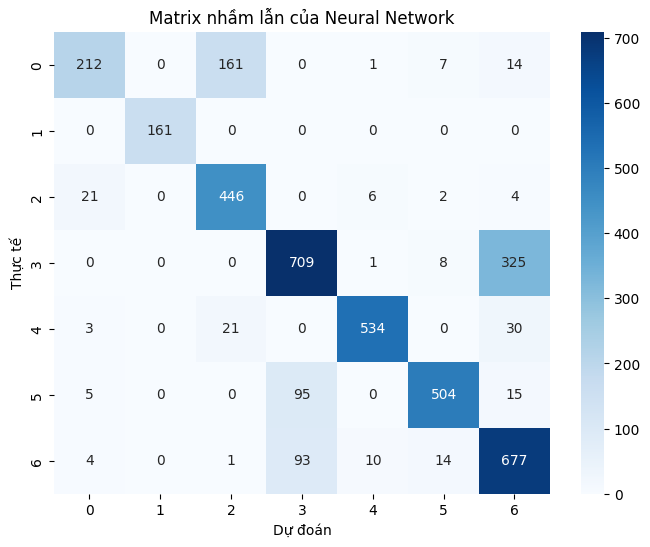

In [41]:
# Phân tích và so sánh kết quả
for model_name, result in results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(result["Confusion Matrix"], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrix nhầm lẫn của {model_name}')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.793585   0.814494  0.793585  0.793310
1          Naive Bayes  0.642507   0.742048  0.642507  0.590278
2  K-Nearest Neighbors  0.785015   0.800577  0.785015  0.786581
3       Neural Network  0.794074   0.814570  0.794074  0.793978


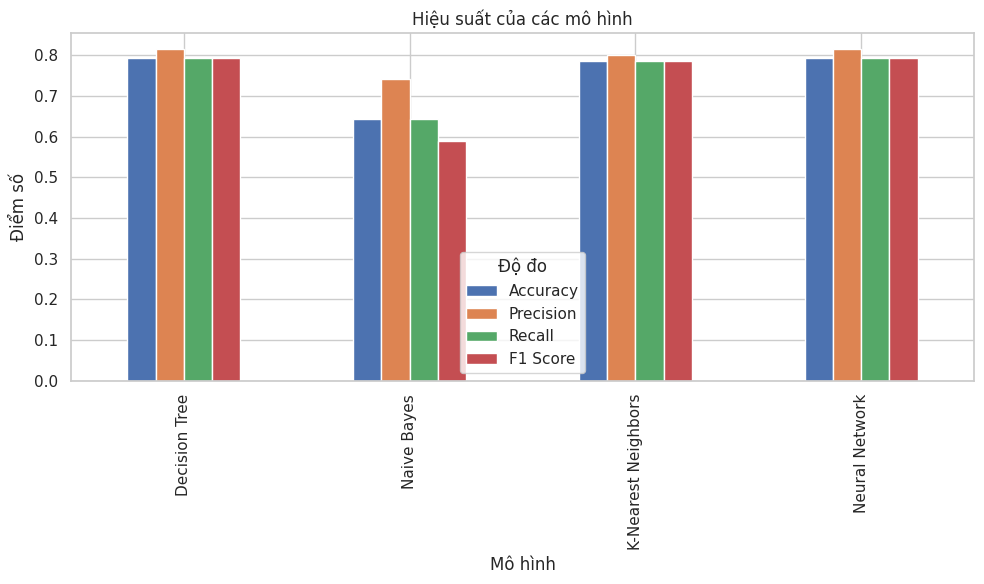

In [42]:
# Tóm tắt kết quả
summary = {
    "Model": list(results.keys()),
    "Accuracy": [results[model]["Accuracy"] for model in results],
    "Precision": [results[model]["Precision"] for model in results],
    "Recall": [results[model]["Recall"] for model in results],
    "F1 Score": [results[model]["F1 Score"] for model in results]
}

summary_df = pd.DataFrame(summary)
print(summary_df)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
summary_df.set_index('Model').plot(kind='bar', ax=ax)
ax.set_title('Hiệu suất của các mô hình')
ax.set_xlabel('Mô hình')
ax.set_ylabel('Điểm số')
ax.legend(title='Độ đo')
plt.tight_layout()
plt.show()